#### **Objective**

The goal is to benchmark different portfolio selection strategies. The idea is to simulate investing 10,000 USD at the beginning of each month using different portfolio allocation models, and then compare which strategy delivers the best performance over time.

The comparison will be based on:

- The evolution of the portfolio's total value over time.
- The allocation method used each month (e.g., Markowitz, equal-weight, etc.).
- Key metrics such as total return, volatility, and Sharpe ratio.


#### **1. Imports**

In [33]:
# %pip install selenium pandas

In [34]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from datetime import datetime

#### **2. Variables**

In [35]:
adjusted_close_prices_csv = 'data/adjusted_close_prices.csv'

end_date = datetime.today()
start_date = datetime(2010, 10, 31)
# start_date = datetime(end_date.year - 12, 10, 31)


search_all_tickers_flag = False
adjusted_closes_flag = False
execute_equal_weight_flag = False

#####################################

# search_all_tickers_flag = True
# adjusted_closes_flag = True
# execute_equal_weight_flag = True

##### **2. Download - Asset Dataset**

In [36]:
MAX_ATTEMPTS = 10
BASE_URL = "https://finviz.com/screener.ashx"

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
    "Mozilla/5.0 (X11; Linux x86_64)",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64)",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 12_4)"
]

def scrape_finviz_by_exchange_requests(exchange: str):
    exchange_map = {
        "nasdaq": "exch_nasd",
        "nyse": "exch_nyse"
    }

    if exchange.lower() not in exchange_map:
        raise ValueError("Invalid exchange. Use 'nasdaq' or 'nyse'.")

    exchange_code = exchange_map[exchange.lower()]
    all_data = []
    r = 1  # page offset

    while True:
        success = False
        attempts = 0

        while not success and attempts < MAX_ATTEMPTS:
            try:
                headers = {
                    "User-Agent": random.choice(USER_AGENTS)
                }
                params = {
                    "v": "111",
                    "f": exchange_code,
                    "r": r
                }
                response = requests.get(BASE_URL, headers=headers, params=params, timeout=10)
                if response.status_code == 429:
                    raise Exception("HTTP 429 Too Many Requests")
                response.raise_for_status()

                soup = BeautifulSoup(response.text, "html.parser")
                tables = soup.find_all("table")

                target_table = None
                for table in tables:
                    rows = table.find_all("tr")
                    if len(rows) < 2:
                        continue
                    cols = rows[1].find_all("td")
                    if len(cols) >= 11 and cols[0].text.strip().isdigit():
                        target_table = table
                        break

                if not target_table:
                    raise ValueError("No valid table found.")

                rows = target_table.find_all("tr")[1:]
                if not rows:
                    print(f"No more data on page starting at {r}. Stopping.")
                    return finalize(all_data, exchange)

                for row in rows:
                    cols = row.find_all("td")
                    if len(cols) >= 11:
                        ticker = cols[1].text.strip()
                        company = cols[2].text.strip()
                        sector = cols[3].text.strip()
                        industry = cols[4].text.strip()
                        country = cols[5].text.strip()
                        market_cap = cols[6].text.strip()
                        volume = cols[10].text.strip()
                        all_data.append([ticker, company, sector, industry, country, market_cap, volume])

                print(f"Page {r} OK")
                success = True
                r += 20

                # Simula navegação humana
                time.sleep(random.uniform(3, 6))

            except Exception as e:
                attempts += 1
                print(f"Error on page {r}, attempt {attempts}: {e}")
                time.sleep(5 * attempts + random.uniform(1, 3))  # backoff crescente

        if not success:
            print(f"\n⚠️  Page {r} failed {MAX_ATTEMPTS} times. Finalizing with partial data.")
            return finalize(all_data, exchange)

def finalize(all_data, exchange):
    df = pd.DataFrame(all_data, columns=[
        "Ticker", "Company", "Sector", "Industry", "Country", "Market Cap", "Volume"
    ])
    df = df[df["Volume"] != "0"].reset_index(drop=True)
    filename = f"data/tickers_{exchange.lower()}.csv"
    df.to_csv(filename, index=False)
    print(f"\n✅ Scraping finished. Saved {len(df)} tickers to '{filename}'")
    return df


##### **2.1 Nasdaq Tickers**

In [37]:
if search_all_tickers_flag:
    nasdaq = scrape_finviz_by_exchange_requests("nasdaq")
    nasdaq

nasdaq = pd.read_csv("data/tickers_nasdaq.csv")
nasdaq

Ticker                                            Company  \
0      AACB                          Artius II Acquisition Inc   
1      AACG                          ATA Creativity Global ADR   
2      AACI                        Armada Acquisition Corp. II   
3      AADR                AdvisorShares Dorsey Wright ADR ETF   
4       AAL                        American Airlines Group Inc   
...     ...                                                ...   
4231   ZVSA                           ZyVersa Therapeutics Inc   
4232   ZYBT                  Zhengye Biotechnology Holding Ltd   
4233   ZYME                                   Zymeworks BC Inc   
4234   ZYXI                                          Zynex Inc   
4235    ZZZ  Cyber Hornet S&P 500 and Bitcoin 75 /25 Strate...   

                  Sector                                  Industry Country  \
0              Financial                           Shell Companies     USA   
1     Consumer Defensive             Education & Training Services   China   
2              Financial                           Shell Companies     USA   
3              Financial                      Exchange Traded Fund     USA   
4            Industrials                                  Airlines     USA   
...                  ...                                       ...     ...   
4231          Healthcare                             Biotechnology     USA   
4232          Healthcare  Drug Manufacturers - Specialty & Generic   China   
4233          Healthcare                             Biotechnology     USA   
4234          Healthcare                      Medical Distribution     USA   
4235           Financial                      Exchange Traded Fund     USA   

     Market Cap      Volume  
0       298.12M           1  
1        67.45M     254,981  
2       321.12M           3  
3             -          20  
4         7.28B  24,043,012  
...         ...         ...  
4231      0.93M      18,248  
4232    256.85M       6,705  
4233    879.92M     402,780  
4234     42.03M     840,704  
4235          -         809  

[4236 rows x 7 columns]

##### **2.2 Nyse Tickers**


In [38]:
if search_all_tickers_flag:
    nyse = scrape_finviz_by_exchange_requests("nyse")
    nyse

nyse = pd.read_csv("data/tickers_nyse.csv")
nyse

Ticker                                         Company  \
0         A                        Agilent Technologies Inc   
1        AA                                      Alcoa Corp   
2       AAA  Alternative Access First Priority CLO Bond ETF   
3      AACT                 Ares Acquisition Corporation II   
4       AAM                     AA Mission Acquisition Corp   
...     ...                                             ...   
4669    ZTO                    ZTO Express (Cayman) Inc ADR   
4670    ZTR                    Virtus Total Return Fund Inc   
4671    ZTS                                      Zoetis Inc   
4672   ZVIA                                       Zevia PBC   
4673    ZWS                 Zurn Elkay Water Solutions Corp   

                  Sector                                  Industry Country  \
0             Healthcare                    Diagnostics & Research     USA   
1        Basic Materials                                  Aluminum     USA   
2              Financial                      Exchange Traded Fund     USA   
3              Financial                           Shell Companies     USA   
4              Financial                           Shell Companies     USA   
...                  ...                                       ...     ...   
4669         Industrials            Integrated Freight & Logistics   China   
4670           Financial                  Closed-End Fund - Equity     USA   
4671          Healthcare  Drug Manufacturers - Specialty & Generic     USA   
4672  Consumer Defensive                 Beverages - Non-Alcoholic     USA   
4673         Industrials            Pollution & Treatment Controls     USA   

     Market Cap     Volume  
0        32.14B    682,198  
1         7.44B  3,594,093  
2             -      6,048  
3       705.51M    209,977  
4       459.97M      2,413  
...         ...        ...  
4669     12.03B  2,439,145  
4670    342.65M    128,272  
4671     65.41B  1,582,264  
4672    219.33M    239,408  
4673      7.41B  1,115,303  

[4674 rows x 7 columns]

In [39]:
tickers = pd.concat([nasdaq, nyse], ignore_index=True)
tickers

Ticker                              Company              Sector  \
0      AACB            Artius II Acquisition Inc           Financial   
1      AACG            ATA Creativity Global ADR  Consumer Defensive   
2      AACI          Armada Acquisition Corp. II           Financial   
3      AADR  AdvisorShares Dorsey Wright ADR ETF           Financial   
4       AAL          American Airlines Group Inc         Industrials   
...     ...                                  ...                 ...   
8905    ZTO         ZTO Express (Cayman) Inc ADR         Industrials   
8906    ZTR         Virtus Total Return Fund Inc           Financial   
8907    ZTS                           Zoetis Inc          Healthcare   
8908   ZVIA                            Zevia PBC  Consumer Defensive   
8909    ZWS      Zurn Elkay Water Solutions Corp         Industrials   

                                      Industry Country Market Cap      Volume  
0                              Shell Companies     USA    298.12M           1  
1                Education & Training Services   China     67.45M     254,981  
2                              Shell Companies     USA    321.12M           3  
3                         Exchange Traded Fund     USA          -          20  
4                                     Airlines     USA      7.28B  24,043,012  
...                                        ...     ...        ...         ...  
8905            Integrated Freight & Logistics   China     12.03B   2,439,145  
8906                  Closed-End Fund - Equity     USA    342.65M     128,272  
8907  Drug Manufacturers - Specialty & Generic     USA     65.41B   1,582,264  
8908                 Beverages - Non-Alcoholic     USA    219.33M     239,408  
8909            Pollution & Treatment Controls     USA      7.41B   1,115,303  

[8910 rows x 7 columns]

#### **3. Process data**


In [40]:
tickers['Volume'] = tickers['Volume'].str.replace(',', '').astype(float)
tickers.sort_values(by="Volume", inplace=True, ascending=False)
tickers

Ticker                                            Company  \
2236   LOBO                           Lobo Ev Technologies Ltd   
3138   RAYA                    Erayak Power Solution Group Inc   
3724   TNON                                  Tenon Medical Inc   
8060   SOXS        Direxion Daily Semiconductor Bear 3X Shares   
2010   IXHL                            Incannex Healthcare Inc   
...     ...                                                ...   
6555   JDVI  John Hancock Disciplined Value International S...   
6656   KBUF  KraneShares 90% KWEB Defined Outcome January 2...   
4490   AUSM                Allspring Ultra Short Municipal ETF   
7753   ROPE                            Coastal Compass 100 ETF   
0      AACB                          Artius II Acquisition Inc   

                 Sector                                  Industry    Country  \
2236  Consumer Cyclical                        Auto Manufacturers      China   
3138        Industrials              Electrical Equipment & Parts      China   
3724         Healthcare                           Medical Devices        USA   
8060          Financial                      Exchange Traded Fund        USA   
2010         Healthcare  Drug Manufacturers - Specialty & Generic  Australia   
...                 ...                                       ...        ...   
6555          Financial                      Exchange Traded Fund        USA   
6656          Financial                      Exchange Traded Fund        USA   
4490          Financial                      Exchange Traded Fund        USA   
7753          Financial                      Exchange Traded Fund        USA   
0             Financial                           Shell Companies        USA   

     Market Cap       Volume  
2236     13.39M  277221913.0  
3138      4.35M  229545591.0  
3724     12.22M  211413022.0  
8060          -  200627421.0  
2010     38.40M  137451462.0  
...         ...          ...  
6555          -          1.0  
6656          -          1.0  
4490          -          1.0  
7753          -          1.0  
0       298.12M          1.0  

[8910 rows x 7 columns]

#### **4. Filter assets**

##### **4.1 Liquidity: Remove low liquidity**
- Filters out assets with insufficient daily trading volume.

In [41]:
tickers = tickers[tickers['Volume'] > 500_000]
tickers

Ticker                                      Company              Sector  \
2236   LOBO                     Lobo Ev Technologies Ltd   Consumer Cyclical   
3138   RAYA              Erayak Power Solution Group Inc         Industrials   
3724   TNON                            Tenon Medical Inc          Healthcare   
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares           Financial   
2010   IXHL                      Incannex Healthcare Inc          Healthcare   
...     ...                                          ...                 ...   
3060   QDEL                      QuidelOrtho Corporation          Healthcare   
7009    MPC                      Marathon Petroleum Corp              Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF           Financial   
4586     BC                               Brunswick Corp   Consumer Cyclical   
3107    QSG                     QuantaSing Group Ltd ADR  Consumer Defensive   

                                      Industry    Country Market Cap  \
2236                        Auto Manufacturers      China     13.39M   
3138              Electrical Equipment & Parts      China      4.35M   
3724                           Medical Devices        USA     12.22M   
8060                      Exchange Traded Fund        USA          -   
2010  Drug Manufacturers - Specialty & Generic  Australia     38.40M   
...                                        ...        ...        ...   
3060                           Medical Devices        USA      1.53B   
7009            Oil & Gas Refining & Marketing        USA     50.94B   
8065                      Exchange Traded Fund        USA          -   
4586                     Recreational Vehicles        USA      3.70B   
3107             Education & Training Services      China    285.02M   

           Volume  
2236  277221913.0  
3138  229545591.0  
3724  211413022.0  
8060  200627421.0  
2010  137451462.0  
...           ...  
3060     502153.0  
7009     500904.0  
8065     500751.0  
4586     500656.0  
3107     500305.0  

[2034 rows x 7 columns]

##### **4.2 Market Cap: Remove small or undefined market capitalization**
- Excludes microcaps and assets without valid market capitalization data to reduce exposure to volatility, manipulation, and poor fundamentals.

In [42]:
# Ensure tickers is a copy before modification to avoid the warning
tickers = tickers.copy()

# Convert Market Cap to numeric format
def convert_market_cap(val):
    val = val.replace('$', '').replace(',', '').strip()
    if val == '-':
        return np.nan  
    elif val.endswith('B'):
        return float(val.replace('B', '')) * 1e9
    elif val.endswith('M'):
        return float(val.replace('M', '')) * 1e6
    elif val.endswith('K'):
        return float(val.replace('K', '')) * 1e3
    else:
        return float(val)

tickers['market_cap'] = tickers['Market Cap'].apply(convert_market_cap)

# Filter by Volume and Market Cap
tickers = tickers[
    (tickers['Market Cap'] == '-') | (tickers['market_cap'] > 500_000_000)
].copy()

tickers


Ticker                                      Company             Sector  \
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares          Financial   
2754   OPEN                    Opendoor Technologies Inc        Real Estate   
3534   SQQQ      ProShares UltraPro Short QQQ -3x Shares          Financial   
2649   NVDA                                  NVIDIA Corp         Technology   
3776   TSLL           Direxion Daily TSLA Bull 2X Shares          Financial   
...     ...                                          ...                ...   
5387    DXD        ProShares UltraShort Dow 30-2X Shares          Financial   
3060   QDEL                      QuidelOrtho Corporation         Healthcare   
7009    MPC                      Marathon Petroleum Corp             Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF          Financial   
4586     BC                               Brunswick Corp  Consumer Cyclical   

                            Industry Country Market Cap       Volume  \
8060            Exchange Traded Fund     USA          -  200627421.0   
2754            Real Estate Services     USA      1.49B  126981253.0   
3534            Exchange Traded Fund     USA          -  115254308.0   
2649                  Semiconductors     USA   4306.36B  106136868.0   
3776            Exchange Traded Fund     USA          -  105416065.0   
...                              ...     ...        ...          ...   
5387            Exchange Traded Fund     USA          -     503040.0   
3060                 Medical Devices     USA      1.53B     502153.0   
7009  Oil & Gas Refining & Marketing     USA     50.94B     500904.0   
8065            Exchange Traded Fund     USA          -     500751.0   
4586           Recreational Vehicles     USA      3.70B     500656.0   

        market_cap  
8060           NaN  
2754  1.490000e+09  
3534           NaN  
2649  4.306360e+12  
3776           NaN  
...            ...  
5387           NaN  
3060  1.530000e+09  
7009  5.094000e+10  
8065           NaN  
4586  3.700000e+09  

[1755 rows x 8 columns]

In [43]:
print("Tickers with valid Market Cap:")
print(tickers['Country'].unique())

allowed_countries = [
    'USA', 'Canada', 'United Kingdom', 'Switzerland', 'Germany', 'France',
    'Netherlands', 'Japan', 'Australia', 'Denmark', 'Sweden', 'Norway',
    'Finland', 'Ireland', 'Belgium', 'Spain', 'Israel', 'Brazil', 'India'
]

# Filter tickers to include only allowed countries
tickers = tickers[tickers['Country'].isin(allowed_countries)]

print("\nAllowed countries:")
print(tickers['Country'].unique())

tickers

Tickers with valid Market Cap:
['USA' 'China' 'Brazil' 'Canada' 'Denmark' 'Cayman Islands' 'Switzerland'
 'United Kingdom' 'Singapore' 'Australia' 'Finland' 'Netherlands' 'Taiwan'
 'Israel' 'India' 'Mexico' 'Sweden' 'South Africa' 'Belgium' 'Bermuda'
 'Spain' 'Ireland' 'Japan' 'Luxembourg' 'Germany' 'Hong Kong' 'Norway'
 'Colombia' 'Monaco' 'France' 'Italy' 'Turkey' 'Cyprus' 'Argentina']

Allowed countries:
['USA' 'Brazil' 'Canada' 'Denmark' 'Switzerland' 'United Kingdom'
 'Australia' 'Finland' 'Netherlands' 'Israel' 'India' 'Sweden' 'Belgium'
 'Spain' 'Ireland' 'Japan' 'Germany' 'Norway' 'France']


Ticker                                      Company             Sector  \
8060   SOXS  Direxion Daily Semiconductor Bear 3X Shares          Financial   
2754   OPEN                    Opendoor Technologies Inc        Real Estate   
3534   SQQQ      ProShares UltraPro Short QQQ -3x Shares          Financial   
2649   NVDA                                  NVIDIA Corp         Technology   
3776   TSLL           Direxion Daily TSLA Bull 2X Shares          Financial   
...     ...                                          ...                ...   
5387    DXD        ProShares UltraShort Dow 30-2X Shares          Financial   
3060   QDEL                      QuidelOrtho Corporation         Healthcare   
7009    MPC                      Marathon Petroleum Corp             Energy   
8065   SPBO            SPDR Portfolio Corporate Bond ETF          Financial   
4586     BC                               Brunswick Corp  Consumer Cyclical   

                            Industry Country Market Cap       Volume  \
8060            Exchange Traded Fund     USA          -  200627421.0   
2754            Real Estate Services     USA      1.49B  126981253.0   
3534            Exchange Traded Fund     USA          -  115254308.0   
2649                  Semiconductors     USA   4306.36B  106136868.0   
3776            Exchange Traded Fund     USA          -  105416065.0   
...                              ...     ...        ...          ...   
5387            Exchange Traded Fund     USA          -     503040.0   
3060                 Medical Devices     USA      1.53B     502153.0   
7009  Oil & Gas Refining & Marketing     USA     50.94B     500904.0   
8065            Exchange Traded Fund     USA          -     500751.0   
4586           Recreational Vehicles     USA      3.70B     500656.0   

        market_cap  
8060           NaN  
2754  1.490000e+09  
3534           NaN  
2649  4.306360e+12  
3776           NaN  
...            ...  
5387           NaN  
3060  1.530000e+09  
7009  5.094000e+10  
8065           NaN  
4586  3.700000e+09  

[1677 rows x 8 columns]

#### **5. Download - Adjusted Close Prices**

In [44]:
if adjusted_closes_flag:
    # Get the list of tickers
    tickers_list = tickers['Ticker'].unique().tolist()

    # Download adjusted close prices
    data = yf.download(
        tickers=tickers_list,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        progress=True,
        group_by='ticker',
        auto_adjust=False
    )

    # Extract only the adjusted close prices
    adjusted_closes = {
        ticker: data[ticker]['Adj Close']
        for ticker in tickers_list if ticker in data
    }

    # Combine into a single DataFrame
    df = pd.DataFrame(adjusted_closes)

    # Save to CSV (optional)
    df.to_csv(adjusted_close_prices_csv)

# Read the CSV file containing adjusted close prices
# index_col=0 => Use the first column (dates) as the DataFrame index
# parse_dates=True => Parse the index column as datetime objects
df_adjusted_close_prices = pd.read_csv(adjusted_close_prices_csv, index_col=0, parse_dates=True)

df_adjusted_close_prices

SOXS  OPEN         SQQQ        NVDA   TSLL       SOXL  \
Date                                                                       
2010-11-01  92477776.00   NaN  943712.1875    0.275998    NaN   0.563285   
2010-11-02  90729920.00   NaN  914895.0000    0.281729    NaN   0.574208   
2010-11-03  87750616.00   NaN  901394.7500    0.283792    NaN   0.593172   
2010-11-04  79567440.00   NaN  868423.3125    0.284251    NaN   0.647634   
2010-11-05  78097640.00   NaN  867904.1250    0.289064    NaN   0.661135   
...                 ...   ...          ...         ...    ...        ...   
2025-07-28         7.23  2.34      18.0800  176.750000  11.95  26.879999   
2025-07-29         7.20  2.05      18.1700  175.509995  11.64  27.030001   
2025-07-30         7.06  2.07      18.1000  179.270004  11.47  27.610001   
2025-07-31         7.72  1.84      18.4200  177.869995  10.68  24.980000   
2025-08-01         8.01  2.10      19.5200  173.720001  10.32  24.080000   

                    SPXS         SPY       TQQQ        AMZN  ...        STIP  \
Date                                                         ...               
2010-11-01  12017.906250   90.718079   0.652616    8.129000  ...         NaN   
2010-11-02  11711.159180   91.437523   0.672399    8.230500  ...         NaN   
2010-11-03  11579.696289   91.804909   0.682116    8.423500  ...         NaN   
2010-11-04  10933.336914   93.572906   0.706282    8.446500  ...         NaN   
2010-11-05  10779.963867   93.924919   0.707130    8.538500  ...         NaN   
...                  ...         ...        ...         ...  ...         ...   
2025-07-28      4.340000  636.940002  89.790001  232.789993  ...  102.540939   
2025-07-29      4.370000  635.260010  89.379997  231.009995  ...  102.740341   
2025-07-30      4.390000  634.460022  89.690002  230.190002  ...  102.590790   
2025-07-31      4.450000  632.080017  88.209999  234.110001  ...  102.521004   
2025-08-01      4.660000  621.719971  82.919998  214.750000  ...  102.919998   

                 EXG  LFST  KODK        ALLE          DXD       QDEL  \
Date                                                                   
2010-11-01  2.502239   NaN   NaN         NaN  1596.174561  11.650000   
2010-11-02  2.518130   NaN   NaN         NaN  1578.044556  12.020000   
2010-11-03  2.543108   NaN   NaN         NaN  1568.281738  11.960000   
2010-11-04  2.588521   NaN   NaN         NaN  1508.311768  12.350000   
2010-11-05  2.620310   NaN   NaN         NaN  1506.220093  12.370000   
...              ...   ...   ...         ...          ...        ...   
2025-07-28  8.840000  4.17  6.93  163.669998    23.540001  26.090000   
2025-07-29  8.810000  4.13  6.92  164.110001    23.750000  25.440001   
2025-07-30  8.800000  4.23  6.86  164.820007    23.959999  24.290001   
2025-07-31  8.750000  3.98  6.70  165.919998    24.320000  23.020000   
2025-08-01  8.550000  3.79  6.45  165.130005    24.969999  22.809999   

                   MPC       SPBO         BC  
Date                                          
2010-11-01         NaN        NaN  12.757085  
2010-11-02         NaN        NaN  13.303104  
2010-11-03         NaN        NaN  13.311378  
2010-11-04         NaN        NaN  13.650576  
2010-11-05         NaN        NaN  14.428245  
...                ...        ...        ...  
2025-07-28  174.800003  28.895388  60.310001  
2025-07-29  175.429993  29.044743  61.189999  
2025-07-30  170.779999  28.985001  59.160000  
2025-07-31  170.190002  28.985001  58.290001  
2025-08-01  165.529999  29.209999  56.639999  

[3710 rows x 1677 columns]

In [45]:
df_adjusted_close_prices['VOO']

Date
2010-11-01     83.027992
2010-11-02     83.671623
2010-11-03     84.024078
2010-11-04     85.602516
2010-11-05     85.939651
                 ...    
2025-07-28    585.440002
2025-07-29    583.919983
2025-07-30    583.210022
2025-07-31    581.020020
2025-08-01    571.450012
Name: VOO, Length: 3710, dtype: float64

In [46]:
# Count the number of columns with at least one null value
null_counts = df_adjusted_close_prices.isnull().any(axis=0).sum()
print(f"{null_counts} columns contain at least one null value.")

# List columns that contain any null values
cols_with_nulls = df_adjusted_close_prices.isnull().any()[lambda x: x].index.tolist()
print("Columns with null values:", cols_with_nulls)

# Remove columns that contain any null values
df_adjusted_close_prices = df_adjusted_close_prices.loc[:, ~df_adjusted_close_prices.isnull().any()].copy()
df_adjusted_close_prices

755 columns contain at least one null value.
Columns with null values: ['OPEN', 'TSLL', 'SOFI', 'ULTY', 'LCID', 'BBAI', 'FIG', 'RKT', 'HOOD', 'IBIT', 'AVTR', 'PLTR', 'JOBY', 'RIOT', 'APLD', 'MARA', 'CONY', 'ETHA', 'QBTS', 'RGTI', 'SNAP', 'RIVN', 'RDDT', 'CONI', 'QS', 'AMDL', 'TSLS', 'TSLQ', 'SGOV', 'HIMS', 'ACHR', 'KWEB', 'SMR', 'SOUN', 'MSTY', 'COIN', 'NVTS', 'ENVX', 'TLRY', 'IREN', 'OKLO', 'TSLY', 'BITF', 'NVD', 'OSCR', 'FUBO', 'IONQ', 'NVDD', 'NCLH', 'SPDN', 'RXRX', 'BE', 'PHLT', 'SCHD', 'HLN', 'RKLB', 'CONL', 'AMCR', 'DOW', 'MP', 'CNH', 'META', 'CIFR', 'BTBT', 'LABD', 'AUR', 'NVDL', 'MSOS', 'NVOX', 'MRNA', 'GDXD', 'CLSK', 'CFLT', 'ROKU', 'CRCL', 'KHC', 'ADT', 'SMCZ', 'UBER', 'BITO', 'PANW', 'EOSE', 'PTON', 'IEMG', 'RBLX', 'TROX', 'IR', 'CCCS', 'KOS', 'MIR', 'KMI', 'SCHH', 'HCMAU', 'UWMC', 'NBIS', 'LYFT', 'VTEB', 'CORZ', 'PYPL', 'XLRE', 'ETHD', 'COMP', 'ANET', 'SLDP', 'CRWV', 'AAPU', 'PATH', 'OWL', 'HPE', 'USAR', 'PR', 'VRT', 'NFE', 'JDST', 'WSC', 'PINS', 'QYLD', 'BKLN', 'JEPQ', 'TM

SOXS         SQQQ        NVDA       SOXL          SPXS  \
Date                                                                        
2010-11-01  92477776.00  943712.1875    0.275998   0.563285  12017.906250   
2010-11-02  90729920.00  914895.0000    0.281729   0.574208  11711.159180   
2010-11-03  87750616.00  901394.7500    0.283792   0.593172  11579.696289   
2010-11-04  79567440.00  868423.3125    0.284251   0.647634  10933.336914   
2010-11-05  78097640.00  867904.1250    0.289064   0.661135  10779.963867   
...                 ...          ...         ...        ...           ...   
2025-07-28         7.23      18.0800  176.750000  26.879999      4.340000   
2025-07-29         7.20      18.1700  175.509995  27.030001      4.370000   
2025-07-30         7.06      18.1000  179.270004  27.610001      4.390000   
2025-07-31         7.72      18.4200  177.869995  24.980000      4.450000   
2025-08-01         8.01      19.5200  173.720001  24.080000      4.660000   

                   SPY       TQQQ        AMZN       VALE        TSLA  ...  \
Date                                                                  ...   
2010-11-01   90.718079   0.652616    8.129000  13.853717    1.427333  ...   
2010-11-02   91.437523   0.672399    8.230500  14.110106    1.416667  ...   
2010-11-03   91.804909   0.682116    8.423500  13.870806    1.451333  ...   
2010-11-04   93.572906   0.706282    8.446500  14.443416    1.660000  ...   
2010-11-05   93.924919   0.707130    8.538500  14.451964    1.629333  ...   
...                ...        ...         ...        ...         ...  ...   
2025-07-28  636.940002  89.790001  232.789993   9.840000  325.589996  ...   
2025-07-29  635.260010  89.379997  231.009995   9.890000  321.200012  ...   
2025-07-30  634.460022  89.690002  230.190002   9.630000  319.040009  ...   
2025-07-31  632.080017  88.209999  234.110001   9.530000  308.269989  ...   
2025-08-01  621.719971  82.919998  214.750000   9.710000  302.630005  ...   

                  CROX        CRI        GRMN        ASB       EXLS  \
Date                                                                  
2010-11-01   14.220000  19.117908   20.512039   8.339033   3.798000   
2010-11-02   14.080000  19.803411   20.302914   8.358937   3.914000   
2010-11-03   14.130000  19.689159   19.226576   8.491621   3.814000   
2010-11-04   14.800000  20.869753   19.595604   8.810303   4.120000   
2010-11-05   14.460000  21.364843   19.171223   8.976287   4.058000   
...                ...        ...         ...        ...        ...   
2025-07-28  105.639999  26.530001  236.360001  25.410000  42.220001   
2025-07-29  104.300003  25.590000  239.300003  25.230000  42.200001   
2025-07-30  102.230003  24.660000  221.490005  25.170000  42.790001   
2025-07-31   99.730003  24.240000  218.759995  24.740000  43.430000   
2025-08-01   97.129997  23.650000  218.729996  24.090000  42.160000   

                   WSM       EXG          DXD       QDEL         BC  
Date                                                                 
2010-11-01   11.695259  2.502239  1596.174561  11.650000  12.757085  
2010-11-02   12.122484  2.518130  1578.044556  12.020000  13.303104  
2010-11-03   12.225731  2.543108  1568.281738  11.960000  13.311378  
2010-11-04   12.773999  2.588521  1508.311768  12.350000  13.650576  
2010-11-05   12.838082  2.620310  1506.220093  12.370000  14.428245  
...                ...       ...          ...        ...        ...  
2025-07-28  188.229996  8.840000    23.540001  26.090000  60.310001  
2025-07-29  187.110001  8.810000    23.750000  25.440001  61.189999  
2025-07-30  190.529999  8.800000    23.959999  24.290001  59.160000  
2025-07-31  187.050003  8.750000    24.320000  23.020000  58.290001  
2025-08-01  187.669998  8.550000    24.969999  22.809999  56.639999  

[3710 rows x 922 columns]

#### **6. Calculate Monthly Log Returns**
- Portfolio models (Markowitz, Equal Weight, etc.) work on returns, not raw prices.
- Using monthly log returns avoids lookahead bias and is standard for multi-asset backtesting.
- Log returns are more robust, easier to analyze statistically, and preferred for multi-period backtests and portfolio analysis.

In [47]:
# Resample monthly, get last price (assigned to month end)
df_monthly_prices = df_adjusted_close_prices.resample('ME').last()

# For the last row, if the date is after the last real available date, fix it:
last_real_date = df_adjusted_close_prices.index[-1]
if df_monthly_prices.index[-1] > last_real_date:
    # Replace the index
    df_monthly_prices.index = list(df_monthly_prices.index[:-1]) + [last_real_date]

In [48]:
# Calculate log returns: log(P_t / P_{t-1})
df_log_returns = np.log(df_monthly_prices / df_monthly_prices.shift(1)).dropna()
# df_log_returns.index = df_log_returns.index.strftime('%Y-%m-%d')

# Use the most recent date from df_adjusted_close_prices as the last date in df_log_returns
last_adj_close_date = df_adjusted_close_prices.index.max()#.strftime('%Y-%m-%d')
dates = list(df_log_returns.index)
dates[-1] = last_adj_close_date
df_log_returns.index = dates

df_log_returns.sort_index(ascending=False)


SOXS      SQQQ      NVDA      SOXL      SPXS       SPY  \
2025-08-01  0.036876  0.058003 -0.023608 -0.036694  0.046111 -0.016526   
2025-07-31 -0.021782 -0.060561  0.118521 -0.005191 -0.052529  0.022770   
2025-06-30 -0.490277 -0.180493  0.156364  0.443265 -0.143559  0.050109   
2025-05-31 -0.375176 -0.269181  0.215624  0.285006 -0.186898  0.060949   
2025-04-30 -0.429908 -0.210573  0.004970 -0.271307 -0.080394 -0.008708   
...              ...       ...       ...       ...       ...       ...   
2011-04-30 -0.108233 -0.093186  0.080126  0.068297 -0.093879  0.028550   
2011-03-31  0.103403 -0.006671 -0.204995 -0.158866 -0.021673  0.000120   
2011-02-28 -0.157460 -0.104969 -0.054113  0.109113 -0.112209  0.034148   
2011-01-31 -0.230689 -0.093388  0.440347  0.188670 -0.074547  0.023033   
2010-12-31 -0.173216 -0.147900  0.123563  0.153651 -0.202638  0.064713   

                TQQQ      AMZN      VALE      TSLA  ...      CROX       CRI  \
2025-08-01 -0.061844 -0.086317  0.018712 -0.018465  ... -0.026416 -0.024641   
2025-07-31  0.060880  0.064940 -0.018712 -0.030006  ... -0.015422 -0.217517   
2025-06-30  0.173141  0.067792  0.061591 -0.086786  ... -0.007084 -0.032329   
2025-05-31  0.243346  0.105843 -0.019523  0.205293  ...  0.056259 -0.052169   
2025-04-30 -0.043152 -0.031176 -0.069494  0.085029  ... -0.096610 -0.213109   
...              ...       ...       ...       ...  ...       ...       ...   
2011-04-30  0.082290  0.083466  0.013393 -0.005420  ...  0.119774  0.076948   
2011-03-31 -0.023801  0.038712 -0.026045  0.149776  ...  0.010707 -0.001047   
2011-02-28  0.087471  0.021288 -0.017377 -0.008752  ...  0.074064  0.034070   
2011-01-31  0.077022 -0.059278  0.012758 -0.099826  ... -0.043576 -0.063297   
2010-12-31  0.138140  0.025888  0.087301 -0.282694  ... -0.024806 -0.070325   

                GRMN       ASB      EXLS       WSM       EXG       DXD  \
2025-08-01 -0.000137 -0.026625 -0.029679  0.003309 -0.023122  0.026376   
2025-07-31  0.046982  0.014248 -0.008255  0.139244  0.007520  0.002882   
2025-06-30  0.032416  0.061291 -0.049019  0.009904  0.026088 -0.080055   
2025-05-31  0.082645  0.049092 -0.052727  0.046114  0.068956 -0.076989   
2025-04-30 -0.150083 -0.021082  0.026546 -0.018420  0.001088  0.031602   
...              ...       ...       ...       ...       ...       ...   
2011-04-30  0.010868 -0.016979 -0.020540  0.073437  0.039838 -0.082894   
2011-03-31 -0.002654  0.025922 -0.049353  0.115286  0.008544 -0.024898   
2011-02-28  0.096401  0.035162  0.153401  0.114049  0.011336 -0.067608   
2011-01-31 -0.005176 -0.080373 -0.119530 -0.098254  0.011331 -0.055625   
2010-12-31  0.067749  0.168556  0.038439  0.070214 -0.004737 -0.110132   

                QDEL        BC  
2025-08-01 -0.009164 -0.028715  
2025-07-31 -0.224706  0.053743  
2025-06-30 -0.062215  0.087341  
2025-05-31  0.098609  0.102733  
2025-04-30 -0.229814 -0.156475  
...              ...       ...  
2011-04-30  0.103938 -0.084477  
2011-03-31 -0.095614  0.099132  
2011-02-28 -0.031416  0.145074  
2011-01-31 -0.062096  0.061064  
2010-12-31  0.089720  0.161201  

[177 rows x 922 columns]

#### **7. Models**

#### **Date to Benchmark**


In [49]:
# Find the first January after start_date
first_january_year = start_date.year + 1
first_january = pd.Timestamp(year=first_january_year, month=1, day=31)  # Last business day of January

# Adjust in case there's no price exactly on this day (get first index >= first_january)
benchmark_start_date = df_monthly_prices.index[df_monthly_prices.index >= first_january][0]


print("First date in df_adjusted_close_prices:", df_adjusted_close_prices.index.min().strftime("%Y-%m-%d"))
print("First date in df_log_returns:          ", df_log_returns.index.min())
print("Benchmark start date:                  ", benchmark_start_date.strftime("%Y-%m-%d"))


First date in df_adjusted_close_prices: 2010-11-01
First date in df_log_returns:           2010-12-31 00:00:00
Benchmark start date:                   2011-01-31


In [50]:
# Slice the data from this date onward
df_monthly_prices = df_monthly_prices.loc[benchmark_start_date:]
df_log_returns = df_log_returns.loc[benchmark_start_date:]

In [51]:
df_monthly_prices.sort_index(ascending=False)

SOXS           SQQQ        NVDA       SOXL         SPXS  \
2025-08-01  8.010000e+00      19.520000  173.720001  24.080000     4.660000   
2025-07-31  7.720000e+00      18.420000  177.869995  24.980000     4.450000   
2025-06-30  7.890000e+00      19.570000  157.990005  25.110001     4.690000   
2025-05-31  1.288254e+01      23.441103  135.120621  16.119047     5.414019   
2025-04-30  1.874728e+01      30.681866  108.912437  12.121683     6.526626   
...                  ...            ...         ...        ...          ...   
2011-05-31  4.579749e+07  618930.062500    0.459385   0.868518  7285.240723   
2011-04-30  4.383847e+07  600756.937500    0.458469   0.932993  7101.192383   
2011-03-31  4.884953e+07  659430.500000    0.423166   0.871400  7800.137207   
2011-02-28  4.405072e+07  663844.000000    0.519445   1.021438  7971.037109   
2011-01-31  5.156286e+07  737316.000000    0.548328   0.915851  8917.572266   

                   SPY       TQQQ        AMZN       VALE        TSLA  ...  \
2025-08-01  621.719971  82.919998  214.750000   9.710000  302.630005  ...   
2025-07-31  632.080017  88.209999  234.110001   9.530000  308.269989  ...   
2025-06-30  617.849976  83.000000  219.389999   9.710000  317.660004  ...   
2025-05-31  587.652771  69.804611  205.009995   9.130000  346.459991  ...   
2025-04-30  552.905457  54.726814  184.419998   9.310000  282.160004  ...   
...                ...        ...         ...        ...         ...  ...   
2011-05-31  104.240913   0.881284    9.834500  14.023946    2.009333  ...   
2011-04-30  105.423111   0.920948    9.790500  14.519525    1.840000  ...   
2011-03-31  102.455879   0.848197    9.006500  14.326356    1.850000  ...   
2011-02-28  102.443581   0.868627    8.664500  14.704382    1.592667  ...   
2011-01-31   99.004410   0.795876    8.482000  14.962128    1.606667  ...   

                  CROX        CRI        GRMN        ASB       EXLS  \
2025-08-01   97.129997  23.650000  218.729996  24.090000  42.160000   
2025-07-31   99.730003  24.240000  218.759995  24.740000  43.430000   
2025-06-30  101.279999  30.129999  208.720001  24.389999  43.790001   
2025-05-31  102.000000  31.120001  202.062637  22.940001  45.990002   
2025-04-30   96.419998  32.786610  186.034592  21.841019  48.480000   
...                ...        ...         ...        ...        ...   
2011-05-31   22.730000  24.144936   20.961031   9.367812   4.696000   
2011-04-30   20.110001  23.550823   21.053280   9.700222   4.144000   
2011-03-31   17.840000  21.806601   20.825718   9.866324   4.230000   
2011-02-28   17.650000  21.829454   20.881071   9.613853   4.444000   
2011-01-31   16.389999  21.098248   18.962105   9.281689   3.812000   

                   WSM       EXG          DXD       QDEL         BC  
2025-08-01  187.669998  8.550000    24.969999  22.809999  56.639999  
2025-07-31  187.050003  8.750000    24.320000  23.020000  58.290001  
2025-06-30  162.736481  8.684449    24.250000  28.820000  55.240002  
2025-05-31  161.132721  8.460821    26.271151  30.670000  50.619999  
2025-04-30  153.871002  7.897058    28.373638  27.790001  45.677860  
...                ...       ...          ...        ...        ...  
2011-05-31   14.059976  2.616153  1177.083374  15.340000  17.990810  
2011-04-30   15.589873  2.656440  1145.703491  13.270000  19.393232  
2011-03-31   14.486023  2.552691  1244.723145  11.960000  21.102694  
2011-02-28   12.908653  2.530975  1276.102905  13.160000  19.111092  
2011-01-31   11.517283  2.502446  1365.360596  13.580000  16.530300  

[176 rows x 922 columns]

In [52]:
df_log_returns

SOXS      SQQQ      NVDA      SOXL      SPXS       SPY  \
2011-01-31 -0.230689 -0.093388  0.440347  0.188670 -0.074547  0.023033   
2011-02-28 -0.157460 -0.104969 -0.054113  0.109113 -0.112209  0.034148   
2011-03-31  0.103403 -0.006671 -0.204995 -0.158866 -0.021673  0.000120   
2011-04-30 -0.108233 -0.093186  0.080126  0.068297 -0.093879  0.028550   
2011-05-31  0.043718  0.029802  0.001998 -0.071609  0.025588 -0.011277   
...              ...       ...       ...       ...       ...       ...   
2025-04-30 -0.429908 -0.210573  0.004970 -0.271307 -0.080394 -0.008708   
2025-05-31 -0.375176 -0.269181  0.215624  0.285006 -0.186898  0.060949   
2025-06-30 -0.490277 -0.180493  0.156364  0.443265 -0.143559  0.050109   
2025-07-31 -0.021782 -0.060561  0.118521 -0.005191 -0.052529  0.022770   
2025-08-01  0.036876  0.058003 -0.023608 -0.036694  0.046111 -0.016526   

                TQQQ      AMZN      VALE      TSLA  ...      CROX       CRI  \
2011-01-31  0.077022 -0.059278  0.012758 -0.099826  ... -0.043576 -0.063297   
2011-02-28  0.087471  0.021288 -0.017377 -0.008752  ...  0.074064  0.034070   
2011-03-31 -0.023801  0.038712 -0.026045  0.149776  ...  0.010707 -0.001047   
2011-04-30  0.082290  0.083466  0.013393 -0.005420  ...  0.119774  0.076948   
2011-05-31 -0.044024  0.004484 -0.034728  0.088037  ...  0.122468  0.024914   
...              ...       ...       ...       ...  ...       ...       ...   
2025-04-30 -0.043152 -0.031176 -0.069494  0.085029  ... -0.096610 -0.213109   
2025-05-31  0.243346  0.105843 -0.019523  0.205293  ...  0.056259 -0.052169   
2025-06-30  0.173141  0.067792  0.061591 -0.086786  ... -0.007084 -0.032329   
2025-07-31  0.060880  0.064940 -0.018712 -0.030006  ... -0.015422 -0.217517   
2025-08-01 -0.061844 -0.086317  0.018712 -0.018465  ... -0.026416 -0.024641   

                GRMN       ASB      EXLS       WSM       EXG       DXD  \
2011-01-31 -0.005176 -0.080373 -0.119530 -0.098254  0.011331 -0.055625   
2011-02-28  0.096401  0.035162  0.153401  0.114049  0.011336 -0.067608   
2011-03-31 -0.002654  0.025922 -0.049353  0.115286  0.008544 -0.024898   
2011-04-30  0.010868 -0.016979 -0.020540  0.073437  0.039838 -0.082894   
2011-05-31 -0.004391 -0.034869  0.125050 -0.103289 -0.015282  0.027021   
...              ...       ...       ...       ...       ...       ...   
2025-04-30 -0.150083 -0.021082  0.026546 -0.018420  0.001088  0.031602   
2025-05-31  0.082645  0.049092 -0.052727  0.046114  0.068956 -0.076989   
2025-06-30  0.032416  0.061291 -0.049019  0.009904  0.026088 -0.080055   
2025-07-31  0.046982  0.014248 -0.008255  0.139244  0.007520  0.002882   
2025-08-01 -0.000137 -0.026625 -0.029679  0.003309 -0.023122  0.026376   

                QDEL        BC  
2011-01-31 -0.062096  0.061064  
2011-02-28 -0.031416  0.145074  
2011-03-31 -0.095614  0.099132  
2011-04-30  0.103938 -0.084477  
2011-05-31  0.144958 -0.075063  
...              ...       ...  
2025-04-30 -0.229814 -0.156475  
2025-05-31  0.098609  0.102733  
2025-06-30 -0.062215  0.087341  
2025-07-31 -0.224706  0.053743  
2025-08-01 -0.009164 -0.028715  

[176 rows x 922 columns]

##### **7.1 Equal Weight (baseline)**

The Equal Weight model allocates the same weight to every asset in the available universe, regardless of liquidity, size, risk, or performance.

In [53]:
def equal_weight(
    df_monthly_prices: pd.DataFrame,
    invest_date: pd.Timestamp,
    invest_amount: float,
    tickers: list = None
) -> pd.DataFrame:
    """
    Simulate equal-weight portfolio for a single entry date.

    Parameters
    ----------
    df_monthly_prices : pd.DataFrame
        Monthly prices (rows: dates, columns: tickers)
    invest_date : pd.Timestamp
        Single investment date (must be in index)
    invest_amount : float
        Total amount to invest
    tickers : list, optional
        Subset of tickers to include (default: all)

    Returns
    -------
    pd.DataFrame
        Columns: ['entry_date', 'date', 'ticker', 'price', 'shares',
                  'position_value', 'portfolio_value', 'proportion']
    """
    if invest_date not in df_monthly_prices.index:
        raise ValueError("invest_date not in df_monthly_prices index")

    if tickers is None:
        tickers = df_monthly_prices.columns.tolist()
    else:
        tickers = [t for t in tickers if t in df_monthly_prices.columns]

    initial_prices = df_monthly_prices.loc[invest_date, tickers]
    if initial_prices.isnull().any():
        raise ValueError("Missing prices on invest_date")

    n_assets = len(tickers)
    weight = 1.0 / n_assets
    shares = (invest_amount * weight) / initial_prices

    result = []
    for date in df_monthly_prices.loc[invest_date:].index:
        prices = df_monthly_prices.loc[date, tickers]
        if prices.isnull().any():
            continue
        position_values = shares * prices
        total_value = position_values.sum()
        proportions = position_values / total_value
        for ticker in tickers:
            result.append({
                'entry_date': invest_date,
                'date': date,
                'ticker': ticker,
                'price': float(prices[ticker]),
                'shares': float(shares[ticker]),
                'position_value': float(position_values[ticker]),
                'portfolio_value': float(total_value),
                'proportion': float(proportions[ticker])
            })

    df_result = pd.DataFrame(result)
    
    df_result['price'] = df_result['price'].round(2)
    df_result['shares'] = df_result['shares'].round(6)
    df_result['position_value'] = df_result['position_value'].round(2)
    df_result['portfolio_value'] = df_result['portfolio_value'].round(2)
    df_result['proportion'] = df_result['proportion'].round(4)

    return df_result


def simulate_all_entry_dates(
    allocation_func: callable,
    df_monthly_prices: pd.DataFrame,
    invest_amount: float,
    tickers: list = None
) -> pd.DataFrame:
    """
    Run a portfolio allocation function for all valid entry dates.

    Parameters
    ----------
    allocation_func : callable
        A function with the signature:
        (df_monthly_prices, invest_date, invest_amount, tickers)
    df_monthly_prices : pd.DataFrame
        Monthly price data (rows: dates, columns: tickers)
    invest_amount : float
        Amount to invest at each entry point
    tickers : list, optional
        List of tickers to include (default: all columns)

    Returns
    -------
    pd.DataFrame
        Long-form DataFrame of simulation results with 'entry_date'
    """
    if tickers is None:
        tickers = df_monthly_prices.columns.tolist()
    else:
        tickers = [t for t in tickers if t in df_monthly_prices.columns]

    valid_dates = df_monthly_prices.dropna().index

    all_results = []
    for invest_date in valid_dates:
        try:
            df_run = allocation_func(
                df_monthly_prices=df_monthly_prices,
                invest_date=invest_date,
                invest_amount=invest_amount,
                tickers=tickers
            )
            all_results.append(df_run)
        except Exception:
            continue

    df_combined = pd.concat(all_results, ignore_index=True)
    return df_combined

if execute_equal_weight_flag:
    df_all_equal_weight = simulate_all_entry_dates(
        allocation_func=equal_weight,
        df_monthly_prices=df_monthly_prices,
        invest_amount=10_000
    )

    df_all_equal_weight.to_parquet('data/df_all_equal_weight.parquet', index=False)

df_all_equal_weight = pd.read_parquet('data/df_all_equal_weight.parquet')

In [60]:
df_all_equal_weight

entry_date       date ticker        price     shares  position_value  \
0        2011-01-31 2011-01-31   SOXS  51562860.00   0.000000           10.85   
1        2011-01-31 2011-01-31   SQQQ    737316.00   0.000015           10.85   
2        2011-01-31 2011-01-31   NVDA         0.55  19.780100           10.85   
3        2011-01-31 2011-01-31   SOXL         0.92  11.842526           10.85   
4        2011-01-31 2011-01-31   SPXS      8917.57   0.001216           10.85   
...             ...        ...    ...          ...        ...             ...   
14361067 2025-08-01 2025-08-01    WSM       187.67   0.057793           10.85   
14361068 2025-08-01 2025-08-01    EXG         8.55   1.268536           10.85   
14361069 2025-08-01 2025-08-01    DXD        24.97   0.434361           10.85   
14361070 2025-08-01 2025-08-01   QDEL        22.81   0.475493           10.85   
14361071 2025-08-01 2025-08-01     BC        56.64   0.191490           10.85   

          portfolio_value  proportion  
0                 10000.0      0.0011  
1                 10000.0      0.0011  
2                 10000.0      0.0011  
3                 10000.0      0.0011  
4                 10000.0      0.0011  
...                   ...         ...  
14361067          10000.0      0.0011  
14361068          10000.0      0.0011  
14361069          10000.0      0.0011  
14361070          10000.0      0.0011  
14361071          10000.0      0.0011  

[14361072 rows x 8 columns]

In [65]:
# Step 1: Aggregate total position value per entry_date and date
df_summary = df_all_equal_weight.groupby(['entry_date', 'date'], as_index=False)['position_value'].sum()

# Step 2: Calculate percentage change from the initial investment per entry_date
df_summary['initial_value'] = df_summary.groupby('entry_date')['position_value'].transform('first')
df_summary['pct_change_from_entry'] = (df_summary['position_value'] / df_summary['initial_value']) - 1

# Optional: Round for presentation
df_summary['pct_change_from_entry'] = df_summary['pct_change_from_entry'].round(4)

df_summary.sort_values(by=['entry_date', 'date'], ascending=[True, True], inplace=True)
df_summary


entry_date       date  position_value  initial_value  \
0     2011-01-31 2011-01-31        10003.70        10003.7   
1     2011-01-31 2011-02-28        10413.33        10003.7   
2     2011-01-31 2011-03-31        10545.33        10003.7   
3     2011-01-31 2011-04-30        10900.89        10003.7   
4     2011-01-31 2011-05-31        10743.88        10003.7   
...          ...        ...             ...            ...   
15571 2025-06-30 2025-07-31        10108.22        10003.7   
15572 2025-06-30 2025-08-01         9999.21        10003.7   
15573 2025-07-31 2025-07-31        10003.70        10003.7   
15574 2025-07-31 2025-08-01         9902.53        10003.7   
15575 2025-08-01 2025-08-01        10003.70        10003.7   

       pct_change_from_entry  
0                     0.0000  
1                     0.0409  
2                     0.0541  
3                     0.0897  
4                     0.0740  
...                      ...  
15571                 0.0104  
15572                -0.0004  
15573                 0.0000  
15574                -0.0101  
15575                 0.0000  

[15576 rows x 5 columns]

In [66]:
# Step: Get the last date's data per entry_date
df_last = df_summary.groupby('entry_date').tail(1).reset_index(drop=True)

# Optional: Select only relevant columns
df_last = df_last[['entry_date', 'date', 'position_value', 'pct_change_from_entry']]
df_last

entry_date       date  position_value  pct_change_from_entry
0   2011-01-31 2025-08-01        63238.90                 5.3216
1   2011-02-28 2025-08-01        61074.36                 5.1052
2   2011-03-31 2025-08-01        60646.69                 5.0624
3   2011-04-30 2025-08-01        59350.27                 4.9328
4   2011-05-31 2025-08-01        59531.17                 4.9509
..         ...        ...             ...                    ...
171 2025-04-30 2025-08-01        11154.50                 0.1150
172 2025-05-31 2025-08-01        10529.27                 0.0525
173 2025-06-30 2025-08-01         9999.21                -0.0004
174 2025-07-31 2025-08-01         9902.53                -0.0101
175 2025-08-01 2025-08-01        10003.70                 0.0000

[176 rows x 4 columns]

In [67]:
import plotly.express as px

fig = px.line(
    df_last,
    x='entry_date',
    y='position_value',
    title='Final Portfolio Value by Entry Date (Equal Weight)',
    markers=True,
    labels={'entry_date': 'Entry Date', 'position_value': 'Final Portfolio Value ($)'},
    hover_data={'position_value': ':.2f', 'pct_change_from_entry': ':.2%'},  # formatted hover
)

fig.update_layout(
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


In [ ]:
df_equal_weight = df_all_equal_weight[df_all_equal_weight['entry_date'] == '2020-01-31']
# df_equal_weight = df_all_equal_weight[df_all_equal_weight['entry_date'] == '2011-01-31']
df_equal_weight

entry_date       date ticker     price    shares  position_value  \
12198060 2020-01-31 2020-01-31   SOXS  24167.94  0.000449           10.85   
12198061 2020-01-31 2020-01-31   SQQQ   2143.80  0.005059           10.85   
12198062 2020-01-31 2020-01-31   NVDA      5.89  1.842950           10.85   
12198063 2020-01-31 2020-01-31   SOXL     15.73  0.689648           10.85   
12198064 2020-01-31 2020-01-31   SPXS    118.42  0.091587           10.85   
...             ...        ...    ...       ...       ...             ...   
12260751 2020-01-31 2025-08-01    WSM    187.67  0.346162           64.96   
12260752 2020-01-31 2025-08-01    EXG      8.55  2.027999           17.34   
12260753 2020-01-31 2025-08-01    DXD     24.97  0.105540            2.64   
12260754 2020-01-31 2025-08-01   QDEL     22.81  0.141224            3.22   
12260755 2020-01-31 2025-08-01     BC     56.64  0.191206           10.83   

          portfolio_value  proportion  
12198060         10000.00      0.0011  
12198061         10000.00      0.0011  
12198062         10000.00      0.0011  
12198063         10000.00      0.0011  
12198064         10000.00      0.0011  
...                   ...         ...  
12260751         19509.54      0.0033  
12260752         19509.54      0.0009  
12260753         19509.54      0.0001  
12260754         19509.54      0.0002  
12260755         19509.54      0.0006  

[62696 rows x 8 columns]

- **position_value**: Total portfolio market value for each month, representing the sum of all asset positions.
- **pct_change_monthly**: Percentage change in portfolio value compared to the previous month, measuring monthly return.
- **pct_change_since_start**: Percentage change in portfolio value compared to the initial investment month, showing cumulative return.
- **count_positive_months**: Cumulative number of months with positive monthly return up to each date.
- **count_negative_months**: Cumulative number of months with negative monthly return up to each date.
- **max_pct_change_monthly**: Highest monthly percentage return achieved up to each date.
- **min_pct_change_monthly**: Lowest monthly percentage return experienced up to each date.
- **max_pct_change_since_start**: Maximum cumulative percentage return since the start, recorded up to each date.
- **min_pct_change_since_start**: Minimum cumulative percentage return since the start, recorded up to each date.

In [ ]:
portfolio_evolution = df_equal_weight.groupby('date')['position_value'].sum().reset_index()

# Monthly % change (relative to previous month)
portfolio_evolution['pct_change_monthly'] = portfolio_evolution['position_value'].pct_change() * 100

# % change relative to the first month
first_value = portfolio_evolution['position_value'].iloc[0]
portfolio_evolution['pct_change_since_start'] = (portfolio_evolution['position_value'] / first_value - 1) * 100

# Round for easier viewing
portfolio_evolution['pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].round(2)
portfolio_evolution['pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].round(2)

# Cumulative positive and negative months
portfolio_evolution['count_positive_months'] = (portfolio_evolution['pct_change_monthly'] > 0).cumsum()
portfolio_evolution['count_negative_months'] = (portfolio_evolution['pct_change_monthly'] < 0).cumsum()

# Rolling max/min columns
portfolio_evolution['max_pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].cummax()
portfolio_evolution['min_pct_change_monthly'] = portfolio_evolution['pct_change_monthly'].cummin()
portfolio_evolution['max_pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].cummax()
portfolio_evolution['min_pct_change_since_start'] = portfolio_evolution['pct_change_since_start'].cummin()

portfolio_evolution


date  position_value  pct_change_monthly  pct_change_since_start  \
0  2020-01-31        10003.70                 NaN                    0.00   
1  2020-02-29         9184.92               -8.18                   -8.18   
2  2020-03-31         7370.67              -19.75                  -26.32   
3  2020-04-30         8294.33               12.53                  -17.09   
4  2020-05-31         8743.71                5.42                  -12.60   
..        ...             ...                 ...                     ...   
63 2025-04-30        17147.20               -1.19                   71.41   
64 2025-05-31        18279.57                6.60                   82.73   
65 2025-06-30        19537.51                6.88                   95.30   
66 2025-07-31        19867.07                1.69                   98.60   
67 2025-08-01        19509.59               -1.80                   95.02   

    count_positive_months  count_negative_months  max_pct_change_monthly  \
0                       0                      0                     NaN   
1                       0                      1                   -8.18   
2                       0                      2                   -8.18   
3                       1                      2                   12.53   
4                       2                      2                   12.53   
..                    ...                    ...                     ...   
63                     35                     28                   15.12   
64                     36                     28                   15.12   
65                     37                     28                   15.12   
66                     38                     28                   15.12   
67                     38                     29                   15.12   

    min_pct_change_monthly  max_pct_change_since_start  \
0                      NaN                        0.00   
1                    -8.18                        0.00   
2                   -19.75                        0.00   
3                   -19.75                        0.00   
4                   -19.75                        0.00   
..                     ...                         ...   
63                  -19.75                       90.28   
64                  -19.75                       90.28   
65                  -19.75                       95.30   
66                  -19.75                       98.60   
67                  -19.75                       98.60   

    min_pct_change_since_start  
0                         0.00  
1                        -8.18  
2                       -26.32  
3                       -26.32  
4                       -26.32  
..                         ...  
63                      -26.32  
64                      -26.32  
65                      -26.32  
66                      -26.32  
67                      -26.32  

[68 rows x 10 columns]

In [ ]:
# Simulate $10,000 invested in VOO on the same start date as your portfolio
voo_prices = df_monthly_prices.loc[portfolio_evolution['date'], 'VOO'].reset_index(drop=True)

# Number of shares purchased at the beginning
initial_voo_price = voo_prices.iloc[0]
voo_shares = 10_000 / initial_voo_price

# Accumulated value over time
voo_position_value = voo_shares * voo_prices

# Monthly and cumulative % returns
voo_pct_change_monthly = voo_position_value.pct_change() * 100
voo_pct_change_since_start = (voo_position_value / voo_position_value.iloc[0] - 1) * 100

# Add these columns to your comparison DataFrame
portfolio_evolution['voo_position_value'] = voo_position_value.values
portfolio_evolution['voo_pct_change_monthly'] = voo_pct_change_monthly.values
portfolio_evolution['voo_pct_change_since_start'] = voo_pct_change_since_start.values
portfolio_evolution

date  position_value  pct_change_monthly  pct_change_since_start  \
0  2020-01-31        10003.70                 NaN                    0.00   
1  2020-02-29         9184.92               -8.18                   -8.18   
2  2020-03-31         7370.67              -19.75                  -26.32   
3  2020-04-30         8294.33               12.53                  -17.09   
4  2020-05-31         8743.71                5.42                  -12.60   
..        ...             ...                 ...                     ...   
63 2025-04-30        17147.20               -1.19                   71.41   
64 2025-05-31        18279.57                6.60                   82.73   
65 2025-06-30        19537.51                6.88                   95.30   
66 2025-07-31        19867.07                1.69                   98.60   
67 2025-08-01        19509.59               -1.80                   95.02   

    count_positive_months  count_negative_months  max_pct_change_monthly  \
0                       0                      0                     NaN   
1                       0                      1                   -8.18   
2                       0                      2                   -8.18   
3                       1                      2                   12.53   
4                       2                      2                   12.53   
..                    ...                    ...                     ...   
63                     35                     28                   15.12   
64                     36                     28                   15.12   
65                     37                     28                   15.12   
66                     38                     28                   15.12   
67                     38                     29                   15.12   

    min_pct_change_monthly  max_pct_change_since_start  \
0                      NaN                        0.00   
1                    -8.18                        0.00   
2                   -19.75                        0.00   
3                   -19.75                        0.00   
4                   -19.75                        0.00   
..                     ...                         ...   
63                  -19.75                       90.28   
64                  -19.75                       90.28   
65                  -19.75                       95.30   
66                  -19.75                       98.60   
67                  -19.75                       98.60   

    min_pct_change_since_start  voo_position_value  voo_pct_change_monthly  \
0                         0.00        10000.000000                     NaN   
1                        -8.18         9190.027856               -8.099721   
2                       -26.32         8046.661375              -12.441382   
3                       -26.32         9075.514988               12.786093   
4                       -26.32         9505.334862                4.736038   
..                         ...                 ...                     ...   
63                      -26.32        18696.155958               -0.811426   
64                      -26.32        19870.580059                6.281634   
65                      -26.32        20898.430474                5.172725   
66                      -26.32        21376.346066                2.286849   
67                      -26.32        21024.255292               -1.647105   

    voo_pct_change_since_start  
0                     0.000000  
1                    -8.099721  
2                   -19.533386  
3                    -9.244850  
4                    -4.946651  
..                         ...  
63                   86.961560  
64                   98.705801  
65                  108.984305  
66                  113.763461  
67                  110.242553  

[68 rows x 13 columns]

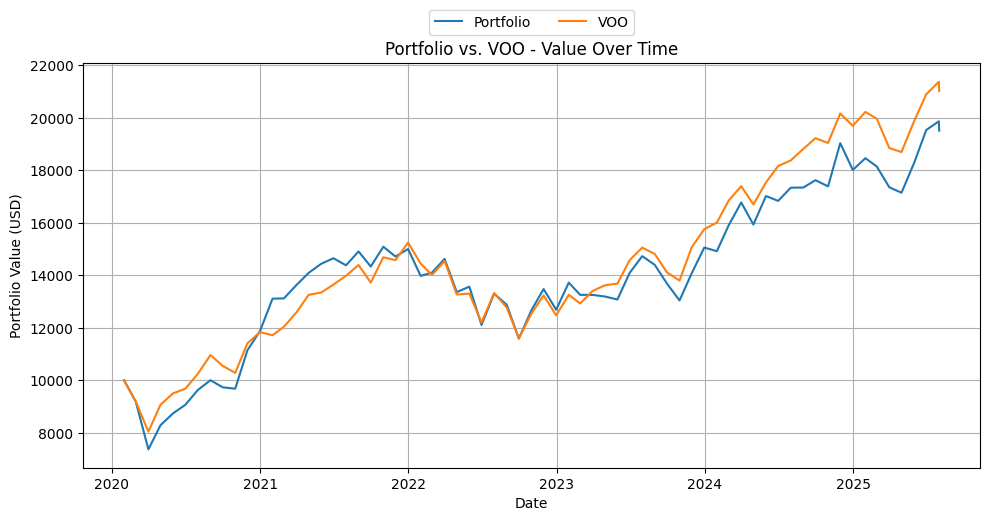

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_evolution['date'], portfolio_evolution['position_value'], label='Portfolio')
plt.plot(portfolio_evolution['date'], portfolio_evolution['voo_position_value'], label='VOO')

plt.title('Portfolio vs. VOO - Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)  # Legend above plot
plt.show()


In [ ]:
# %pip install plotly

In [ ]:
import plotly.graph_objects as go

def plot_each_column_vs_voo(df: pd.DataFrame, columns: list, titles: list = None):
    """
    Plot each specified column from df and VOO columns as separate interactive Plotly charts.
    """
    first_date = df['date'].min() - pd.DateOffset(months=1)
    last_date = df['date'].max() + pd.DateOffset(months=1)
    if titles is None:
        titles = [col.replace('_', ' ').title() for col in columns]
    
    voo_map = {
        'position_value': 'voo_position_value',
        'pct_change_monthly': 'voo_pct_change_monthly',
        'pct_change_since_start': 'voo_pct_change_since_start'
    }
    
    for col, title in zip(columns, titles):
        fig = go.Figure()
        # Portfolio line
        fig.add_trace(go.Scatter(
            x=df['date'],
            y=df[col],
            mode='lines',
            name='Portfolio'
        ))
        # VOO line (if available)
        if col in voo_map:
            fig.add_trace(go.Scatter(
                x=df['date'],
                y=df[voo_map[col]],
                mode='lines',
                name='VOO'
            ))
        fig.update_layout(
            title=title,
            xaxis_title='Date',
            yaxis_title=col.replace('_', ' ').title(),
            hovermode='x unified',
            xaxis=dict(
                range=[first_date, last_date],
                tickformat='%b\n%Y',
                tickangle=0,
                tickmode='auto',
                nticks=12,
                rangeslider=dict(visible=True)
            )
        )
        fig.show()

plot_each_column_vs_voo(
    portfolio_evolution,
    columns=['position_value', 'pct_change_monthly', 'pct_change_since_start'],
    titles=[
        'Portfolio vs. VOO - Value Over Time',
        'Portfolio vs. VOO - Monthly % Change',
        'Portfolio vs. VOO - Cumulative Return Since Start'
    ]
)


##### **7.2 Markowitz (Max Sharpe)**

##### **7.3 Minimum Volatility**

##### **7.4 Momentum**

##### **7.5 Random (baseline)**